In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import random

In [53]:
df = pd.read_pickle('cleaned_df.pkl')

In [54]:
df.head()

,clothing_ID,Age,Title,Text,review_len,Positive_fb_count,Division,Department,Class,Positively_rated,Reco
original_ind,,,,,,,,,,,
0,767,33,absolutely wonderful,absolutely wonderful silky and sexy and comf...,53,0,Initmates,Intimate,Intimates,1,1
1,1080,34,love this dress,love this dress it s sooo pretty i happene...,303,4,General,Dresses,Dresses,1,1
2,1077,60,some major design flaws,i had such high hopes for this dress and reall...,500,0,General,Dresses,Dresses,0,0
3,1049,50,my favorite buy,i love love love this jumpsuit it s fun fl...,124,0,General Petite,Bottoms,Pants,1,1
4,847,47,flattering shirt,this shirt is very flattering to all due to th...,192,6,General,Tops,Blouses,1,1


In [55]:
#define our own train test split, as I wish to keep the train/test as seperate data frames for easy reference
def train_test_split_df (df,test_size = 0.2):
    idx = list(df.index)
    random.shuffle(idx)
    test_len = int(test_size * len(df))
    return df.loc[idx[test_len:]],df.loc[idx[:test_len]]

In [56]:
data_train,data_test = train_test_split_df(df)

In [57]:
data_train.to_pickle('train_set.pkl')
data_test.to_pickle('test_set.pkl')

In [58]:
columns_to_keep = ['clothing_ID','Age','review_len','Positive_fb_count','Division','Department','Class']
categorical_features = ['Division','Department','Class']
data_train_features_only_wo_text = data_train[columns_to_keep]

In [60]:
data_train_features_only_dummied = pd.get_dummies(data_train_features_only_wo_text,categorical_features)

In [61]:
data_test_features_only_wo_text = data_train[columns_to_keep]
data_test_features_only_dummied = pd.get_dummies(data_test_features_only_wo_text,categorical_features)

We will start with our first bag of words model without any lemmatization and stopwords removal

In [70]:
from sklearn.model_selection import train_test_split

# Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(data_train.Text, 
                                                    data_train.Positively_rated, test_size=0.25,
                                                    random_state=0)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data (Bag of Words model)
vect = CountVectorizer().fit(X_train)

In [72]:
vect.get_feature_names()[::1000]

['00',
 'atlanta',
 'chase',
 'described',
 'few',
 'hope',
 'loosens',
 'origami',
 'rath',
 'shower',
 'tagged',
 'waffle']

In [73]:
len(vect.get_feature_names())

11505

In [74]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train).toarray()

In [77]:
X_train_add = data_train_features_only_dummied.loc[list(X_train.index)].to_numpy()

In [79]:
X_train_vect_stack = np.hstack((X_train_vectorized,X_train_add))

In [83]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression()
model.fit(X_train_vect_stack, y_train)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
#X_val need to be treated the same as X_train
X_val_vectorized = vect.transform(X_val).toarray()
X_val_add = data_train_features_only_dummied.loc[list(X_val.index)].to_numpy()
X_val_vect_stack = np.hstack((X_val_vectorized,X_val_add))

In [101]:
from sklearn.metrics import roc_auc_score,accuracy_score, confusion_matrix

# Predict the transformed test documents
predictions = model.predict_proba(X_val_vect_stack)

roc_auc_score(y_val, predictions[:,1])

0.8483767322460243

In [100]:
y_pred = model.predict(X_val_vect_stack)

In [104]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap = 'Greens')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

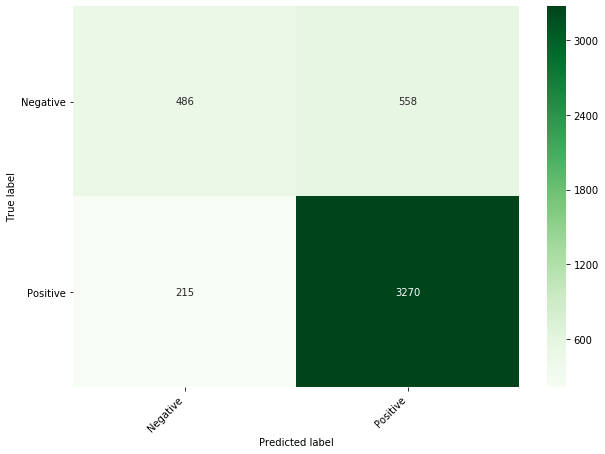

In [105]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

In [106]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Accuracy",accuracy_score(y_true=y_val, y_pred=y_pred),
      "\nRecall",recall_score(y_true=y_val, y_pred=y_pred),
     '\nPrecision',precision_score(y_true=y_val, y_pred=y_pred))

Accuracy 0.8293221461691322 
Recall 0.9383070301291249 
Precision 0.85423197492163


For this project we will maximize accuracy because we want to identify negative and positive comments respectively


In [108]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, predictions[:,1])

ROC AUC score =  0.8483767322460243


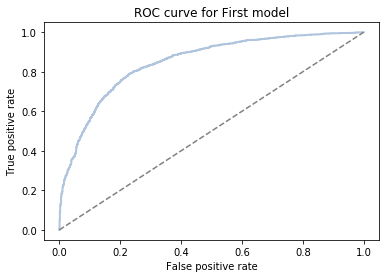

In [118]:
plt.plot(fpr, tpr,lw=2,c='lightsteelblue')
plt.plot([0,1],[0,1],c='grey',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for First model');
print("ROC AUC score = ", roc_auc_score(y_val, predictions[:,1]))
plt.savefig('ROC_first_model.png')